In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import math
import os 
import re
import pandas as pd
import sys
import seaborn as sns
import re

import plotly.graph_objs as go
from databaseMaker import create
from scipy.optimize import minimize

In [2]:
dfDict, backDict = create()

In [46]:
#new dataframe with intensities weighted by position (for centroid plot) 
# wdf=pd.DataFrame()
# for i in df.columns.tolist():
#     wdf[i]=df[i]*df.index

# wdf=pd.DataFrame()
# for i in newdf.columns.tolist():
#     wdf[i]=newdf[i]*newdf.index


#Centroid/maximum data
# linedat=pd.DataFrame()
# linedat['mean']=wdf.mean(axis=0)
# linedat['std']=wdf.std(axis=0)
# linedat['detuning']=linedat.index.tolist()
# linedat['max']=df.idxmax()


lineDict = {}

for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        try:
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()
        except:
            lineDict[k1]={}
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()

fitDict = {}
            
def uglyFun(x,B):
    return B[3]/(B[1]*math.sqrt(2*math.pi))*np.exp(-(x-B[0])**2/(2*B[1]**2)) + B[2]


def uglyChi2(B, args):
    chi2 = 0
#     for bn in range(0, len(args)):
#         if args[bn] is not None:
#             B[bn] = args[bn]
#             chi2 += (B[bn]-args[bn])**2

# no uncertainties in raw data
    return chi2 + np.sum((uglyFun(args[0],B)-args[1])**2)
 
 
for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        try:
            fitDict[k1][k2]=pd.DataFrame()
        except:
            fitDict[k1]={}
            fitDict[k1][k2]=pd.DataFrame()
        for detun in dfDict[k1][k2].columns:
            guess = [dfDict[k1][k2][detun].idxmax(), 100,0, 1000]
            bounds = [(guess[0]-25,guess[0]+25),(0,200),(-50,150),(0,10000)]
            xData=dfDict[k1][k2].index.tolist()[int(guess[0])-50:int(guess[0])+50]
            yData=dfDict[k1][k2][detun].tolist()[int(guess[0])-50:int(guess[0])+50]
            result=minimize(uglyChi2, [400, 1,0, 1000], bounds = bounds, args=([xData,yData]))
            peak=result.x[0]
            fitDict[k1][k2]=pd.concat([fitDict[k1][k2],
                pd.DataFrame({
                'peak':peak,
                'unc':2*result.hess_inv.todense()[0][0]*uglyChi2(result.x,[xData,yData]),
                'detuning':detun}, index=[0])], 
                    ignore_index=True)
#             For checking my fitting work
#             plt.scatter(dfDict[k1][k2].index.tolist(),dfDict[k1][k2][detun], alpha = .4)
#             x= np.linspace(min(xData),max(xData),1000)
#             plt.plot(x,uglyFun(x,result.x),'r-')
#             plt.show()


C:\Users\wahlm\AppData\Local\Temp/ipykernel_18588/180346389.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]/(B[1]*math.sqrt(2*math.pi))*np.exp(-(x-B[0])**2/(2*B[1]**2)) + B[2]
C:\Users\wahlm\AppData\Local\Temp/ipykernel_18588/180346389.py:36: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]/(B[1]*math.sqrt(2*math.pi))*np.exp(-(x-B[0])**2/(2*B[1]**2)) + B[2]
C:\Users\wahlm\AppData\Local\Temp/ipykernel_18588/180346389.py:36: RuntimeWarning: invalid value encountered in true_divide
  return B[3]/(B[1]*math.sqrt(2*math.pi))*np.exp(-(x-B[0])**2/(2*B[1]**2)) + B[2]
C:\Users\wahlm\AppData\Local\Temp/ipykernel_18588/180346389.py:36: RuntimeWarning: invalid value encountered in multiply
  return B[3]/(B[1]*math.sqrt(2*math.pi))*np.exp(-(x-B[0])**2/(2*B[1]**2)) + B[2]
C:\Users\wahlm\AppData\Local\Temp/ipykernel_18588/180346389.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return B[3]/(B[1]*math.sqrt(2*math.pi))*np.ex

TypeError: cannot convert the series to <class 'int'>

(510.0, 250.0)

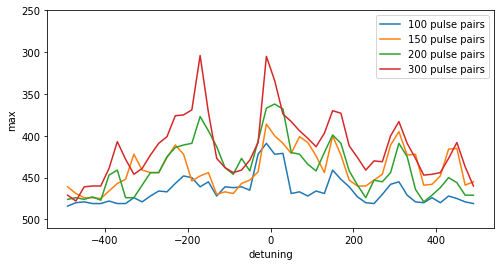

In [38]:
f, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['100'], label='100 pulse pairs')
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['150'], label='150 pulse pairs')
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['200'], label='200 pulse pairs')
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['300'], label='300 pulse pairs')
ax.set_ylim([510,250])



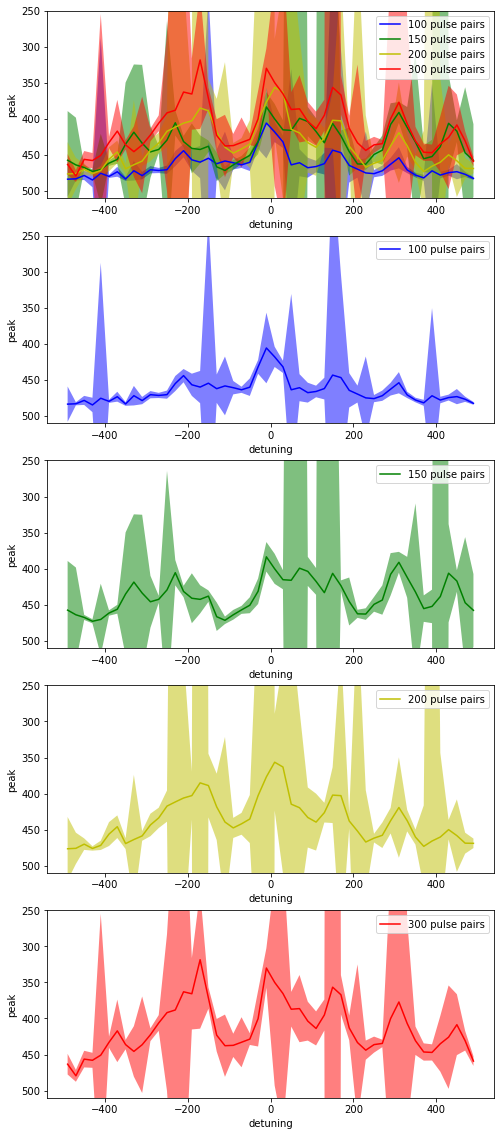

In [57]:
sweep='downdown'
pps=['100','150','200','300']
colors=['b','g','y','r']
f, axs= plt.subplots(5,1,figsize=(8,20))

for num, pp in enumerate(pps):
    sns.lineplot(x='detuning',y='peak',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[0])
    x=fitDict[sweep][pp]['detuning']
    y=fitDict[sweep][pp]['peak']
    yerr=fitDict[sweep][pp]['unc']
    axs[0].fill_between(x, y-yerr, y+yerr,facecolor=colors[num],alpha=0.5)

for num, pp in enumerate(['100','150','200','300']):
    sns.lineplot(x='detuning',y='peak',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[num+1])
    x=fitDict[sweep][pp]['detuning']
    y=fitDict[sweep][pp]['peak']
    yerr=fitDict[sweep][pp]['unc']
    axs[num+1].fill_between(x, y-yerr, y+yerr,facecolor=colors[num],alpha=0.5)

# sns.lineplot(x='detuning',y='peak',data=fitDict['downdown']['150'], color='g', label='150 pulse pairs')
# x=fitDict['downdown']['150']['detuning']
# y=fitDict['downdown']['150']['peak']
# yerr=fitDict['downdown']['150']['unc']
# plt.fill_between(x, y-yerr, y+yerr,facecolor='g',alpha=0.5)

# sns.lineplot(x='detuning',y='peak',data=fitDict['downdown']['200'], color='y',label='200 pulse pairs')
# x=fitDict['downdown']['200']['detuning']
# y=fitDict['downdown']['200']['peak']
# yerr=fitDict['downdown']['200']['unc']
# plt.fill_between(x, y-yerr, y+yerr,facecolor='y',alpha=0.5)

# sns.lineplot(x='detuning',y='peak',data=fitDict['downdown']['300'], color='r',label='300 pulse pairs')
# x=fitDict['downdown']['300']['detuning']
# y=fitDict['downdown']['300']['peak']
# yerr=fitDict['downdown']['300']['unc']
# plt.fill_between(x, y-yerr, y+yerr,facecolor='r',alpha=0.5)



for ax in axs:
    ax.set_ylim([510,250])



In [ ]:
f, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['100'], label='100 pulse pairs')
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['200'], label='200 pulse pairs')
sns.lineplot(x='detuning',y='max',data=lineDict['downdown']['300'], label='300 pulse pairs')
ax.set_ylim([510,250])



In [ ]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,16))

sns.heatmap(dfDict['downdown']['100'], vmin=0, vmax = dfDict['downdown']['300'].max().max(),xticklabels=False,cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=ax1)
sns.heatmap(dfDict['downdown']['150'], vmin=0, vmax = dfDict['downdown']['300'].max().max(),xticklabels=False,cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=ax2)
sns.heatmap(dfDict['downdown']['200'], vmin=0, vmax = dfDict['downdown']['300'].max().max(),xticklabels=False,cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=ax3)
sns.heatmap(dfDict['downdown']['300'], vmin=0, vmax = dfDict['downdown']['300'].max().max(),xticklabels=False,cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=ax4)

ax2.set_ylim([510,100])
ax1.set_ylim([510,100])
ax3.set_ylim([510,100])
ax4.set_ylim([510,100])


In [ ]:
f, ax=plt.subplots(figsize=(8,4))

sns.lineplot(x='detuning',y='max',data=linedat100,ax=ax)
sns.lineplot(x='detuning',y='max',data=linedat200,ax=ax)
ax.set_ylim([510,350])

In [ ]:
#Just testing: what's the shape of the data?
%matplotlib widget
fig, ax = plt.subplots()

line = sns.lineplot(x=df.index,y=10,data=df)
plt.subplots_adjust(left=0.25, bottom=0.25)
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63])
detuning_slider = Slider(
    ax=axamp,
    label='Detuning',
    valmin=df.columns[0],
    valmax=df.columns[-1],
    valstep=20,
    valinit=10,
    orientation="vertical"
)

def update(val):
    line.set_ydata(df[detuning_slider.val])
    fig.canvas.draw_idle()
    
detuning_slider.on_changed(update)

In [ ]:
line = sns.lineplot(x=df200.index,y=10,data=df200)